<a id='top'></a>

# Data Engineering of Understat Data
##### Notebook to engineer raw data scraped from [Understat](https://understat.com/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Last updated: 01/09/2020

![title](../../img/understat-logo-banner.png)

Click [here](#section5) to jump straight to the Exploratory Data Analysis section and skip the [Task Brief](#section2), [Data Sources](#section3), and [Data Engineering](#section4) sections. Or click [here](#section6) to jump straight to the Conclusion.

___

<a id='sectionintro'></a>

## <a id='import_libraries'>Introduction</a>
This notebook engineers scraped data for shooting from [Understat](https://understat.com/) using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/),
*    edd.j.webster@gmail.com,
*    [@eddwebster](https://www.twitter.com/eddwebster),
*    [LinkedIn.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/),
*    [GitHub/eddwebster](https://github.com/eddwebster/),
*    [Kaggle.com/eddwebster](https://www.kaggle.com/eddwebster), and
*    [HackerRank.com/eddwebster](https://www.hackerrank.com/eddwebster).

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/fifa-league) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/fifa-league/blob/master/FIFA%2020%20Fantasy%20Football%20League%20using%20TransferMarkt%20Player%20Valuations.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
      1.    [Introduction](#section4.1)<br>
      2.    [Columns of Interest](#section4.2)<br>
      3.    [String Cleaning](#section4.3)<br>
      4.    [Converting Data Types](#section4.4)<br>
      5.    [Export the Engineered DataFrame](#section4.5)<br>
5.    [Exploratory Data Analysis (EDA)](#section5)<br>
      1.    [...](#section5.1)<br>
      2.    [...](#section5.2)<br>
      3.    [...](#section5.3)<br>
6.    [Summary](#section6)<br>
7.    [Next Steps](#section7)<br>
8.    [Bibliography](#section8)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    `tqdm` for a clean progress bar;
*    `requests` for executing HTTP requests;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd    # version 1.0.3
import os    #  used to read the csv filenames
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os

# Working with JSON
import json
from pandas.io.json import json_normalize

# Web Scraping
import requests
from bs4 import BeautifulSoup
import re

# Fuzzy Matching - Record Linkage
import recordlinkage
import jellyfish
import numexpr as ne

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno    # visually display missing data

# Progress Bar
from tqdm import tqdm    # a clean progress bar library

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.1
pandas: 1.0.1
matplotlib: 3.1.3
Seaborn: 0.10.0


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', )
data_dir = os.path.join(base_dir, 'data')
data_dir_fbref = os.path.join(base_dir, 'data', 'fbref')
data_dir_tm = os.path.join(base_dir, 'data', 'tm')
data_dir_understat = os.path.join(base_dir, 'data', 'understat')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

---

<a id='section2'></a>

## <a id='#section2'>2. Project Brief</a>
This Jupyter notebook explores how to engineer football shooting data from [Understat](https://understat.com/), using [pandas](http://pandas.pydata.org/) for data maniuplation through DataFrames.

The data of player values produced in this notebook is exported to CSV. This data can be further analysed in Python, joined to other datasets, or explored using Tableau, PowerBI, Microsoft Excel.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>
[Understat](https://understat.com/) is a data stats website which is a great source of shooting data including the positions of shots, dating back to the 14/15 season.

Before conducting our EDA, the data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and Cleaned in the Data Engineering section [Section 4](#section4).

We'll be using the [pandas](http://pandas.pydata.org/) library to import our data to this workbook as a DataFrame.

### <a id='#section3.2'>3.2. Data Dictionary</a>
The [Understat](https://understat.com/) dataset has twenty features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `id`    | `int64`
| `minute`    | `int64`
| `result`    | `object`
| `X`    | `float64`
| `Y`    | `float64`
| `xG`    | `float64`
| `player`    | `object`
| `h_a`    | `object`
| `player_id`    | `int64`
| `situation`    | `object`
| `season`    | `int64`
| `shotType`    | `object`
| `match_id`    | `int64`
| `h_team`    | `object`
| `a_team`    | `object`
| `h_goals`    | `int64`
| `a_goals`    | `int64`
| `date`    | `object`
| `player_assisted`    | `object`
| `lastAction`    | `object`

### <a id='#section3.3'>3.3. Creating the DataFrame - scraping the data</a>
The data has been scraped using the [Ben Torvaney](https://twitter.com/Torvaney)'s [Understat Scraper in R](https://gist.github.com/Torvaney/42cd82addb3ba2c4f33ec3247e66889c)

This information collected for all the players is converted to a [pandas](http://pandas.pydata.org/) DataFrame from which we can view and manipulate the data.

##### 14/15

In [5]:
# Import data as a pandas DataFrame, df_understat_1415_raw

## Look for most recent CSV file
list_of_files_1415 = glob.glob(data_dir_understat + '/raw/1415/*')    # * means all if need specific format then *.csv
filepath_latest_1415 = max(list_of_files_1415, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_1415_raw = pd.read_csv(filepath_latest_1415)

##### 15/16

In [6]:
# Import data as a pandas DataFrame, df_understat_1516_raw

## Look for most recent CSV file
list_of_files_1516 = glob.glob(data_dir_understat + '/raw/1516/*')
filepath_latest_1516 = max(list_of_files_1516, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_1516_raw = pd.read_csv(filepath_latest_1516)

##### 16/17

In [7]:
# Import data as a pandas DataFrame, df_understat_1617_raw

## Look for most recent CSV file
list_of_files_1617 = glob.glob(data_dir_understat + '/raw/1617/*')
filepath_latest_1617 = max(list_of_files_1617, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_1617_raw = pd.read_csv(filepath_latest_1617)

##### 17/18

In [8]:
# Import data as a pandas DataFrame, df_understat_1718_raw

## Look for most recent CSV file
list_of_files_1718 = glob.glob(data_dir_understat + '/raw/1718/*')
filepath_latest_1718 = max(list_of_files_1718, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_1718_raw = pd.read_csv(filepath_latest_1718)

##### 18/19

In [9]:
# Import data as a pandas DataFrame, df_understat_1819_raw

## Look for most recent CSV file
list_of_files_1819 = glob.glob(data_dir_understat + '/raw/1819/*')
filepath_latest_1819 = max(list_of_files_1819, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_1819_raw = pd.read_csv(filepath_latest_1819)

##### 19/20

In [10]:
# Import data as a pandas DataFrame, df_understat_1920_raw

## Look for most recent CSV file
list_of_files_1920 = glob.glob(data_dir_understat + '/raw/1920/*')    # * means all if need specific format then *.csv
filepath_latest_1920 = max(list_of_files_1920, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_1920_raw = pd.read_csv(filepath_latest_1920)

##### 20/21

In [ ]:
"""
# COMMENTED OUT AS THE DATA FOR THE LATEST SEASON IS NOT YET AVAILABLE AS OF 01/09/2020

# Import data as a pandas DataFrame, df_understat_2021_raw

## Look for most recent CSV file
list_of_files_2021 = glob.glob(data_dir_understat + '/raw/2021/*')    # * means all if need specific format then *.csv
filepath_latest_2021 = max(list_of_files_2021, key=os.path.getctime)

## Load in most recently parsed CSV file
df_understat_2021_raw = pd.read_csv(filepath_latest_2021)
"""

### <a id='#section3.3'>3.4. Preliminary Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

##### 14/15

In [11]:
# Display the first 5 rows of the raw DataFrame, df_understat_1415_raw
df_understat_1415_raw.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,14511,12,SavedShot,0.728,0.501,0.018741,Wayne Rooney,h,629,OpenPlay,2014,RightFoot,4749,Manchester United,Swansea,1,2,2014-08-16T12:45:00Z,Darren Fletcher,Pass
1,14512,16,BlockedShot,0.789,0.336,0.015598,Wayne Rooney,h,629,OpenPlay,2014,RightFoot,4749,Manchester United,Swansea,1,2,2014-08-16T12:45:00Z,Chicharito,TakeOn
2,14513,25,SavedShot,0.914,0.188,0.064923,Juan Mata,h,554,DirectFreekick,2014,LeftFoot,4749,Manchester United,Swansea,1,2,2014-08-16T12:45:00Z,NaN,Standard
3,14514,26,SavedShot,0.920,0.482,0.057788,Wayne Rooney,h,629,OpenPlay,2014,Head,4749,Manchester United,Swansea,1,2,2014-08-16T12:45:00Z,Ashley Young,Aerial
4,14516,33,MissedShots,0.922,0.590,0.048801,Wayne Rooney,h,629,FromCorner,2014,Head,4749,Manchester United,Swansea,1,2,2014-08-16T12:45:00Z,Juan Mata,Cross


In [12]:
# Display the last 5 rows of the raw DataFrame, ddf_understat_1415_raw
df_understat_1415_raw.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
45743,7438,64,MissedShots,0.693,0.521,0.012393,Corentin Tolisso,a,3603,OpenPlay,2014,RightFoot,5884,Rennes,Lyon,0,1,2015-05-23T20:00:00Z,Clinton N&#039;Jie,Pass
45744,7440,68,MissedShots,0.852,0.233,0.021710,Clinton N&#039;Jie,a,960,OpenPlay,2014,RightFoot,5884,Rennes,Lyon,0,1,2015-05-23T20:00:00Z,Corentin Tolisso,Chipped
45745,7442,77,MissedShots,0.713,0.572,0.013678,Maxime Gonalons,a,3274,OpenPlay,2014,RightFoot,5884,Rennes,Lyon,0,1,2015-05-23T20:00:00Z,Gueida Fofana,Pass
45746,7443,85,SavedShot,0.761,0.649,0.020611,Yassine Benzia,a,3366,OpenPlay,2014,RightFoot,5884,Rennes,Lyon,0,1,2015-05-23T20:00:00Z,Gueida Fofana,Pass
45747,7444,85,Goal,0.917,0.452,0.594141,Clinton N&#039;Jie,a,960,OpenPlay,2014,RightFoot,5884,Rennes,Lyon,0,1,2015-05-23T20:00:00Z,Maxime Gonalons,TakeOn


##### 15/16

In [13]:
# Display the first 5 rows of the raw DataFrame, df_understat_1516_raw
df_understat_1516_raw.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,200247,27,BlockedShot,0.794,0.421,0.104347,Juan Mata,h,554,DirectFreekick,2015,LeftFoot,81,Manchester United,Tottenham,1,0,2015-08-08T15:45:00Z,NaN,Standard
1,200248,27,BlockedShot,0.860,0.627,0.064342,Memphis Depay,h,555,SetPiece,2015,RightFoot,81,Manchester United,Tottenham,1,0,2015-08-08T15:45:00Z,Ashley Young,Pass
2,200249,35,BlockedShot,0.843,0.333,0.057157,Juan Mata,h,554,OpenPlay,2015,LeftFoot,81,Manchester United,Tottenham,1,0,2015-08-08T15:45:00Z,Wayne Rooney,Pass
3,200250,35,MissedShots,0.848,0.533,0.092141,Juan Mata,h,554,OpenPlay,2015,LeftFoot,81,Manchester United,Tottenham,1,0,2015-08-08T15:45:00Z,NaN,Tackle
4,200251,40,BlockedShot,0.812,0.707,0.035742,Memphis Depay,h,555,OpenPlay,2015,RightFoot,81,Manchester United,Tottenham,1,0,2015-08-08T15:45:00Z,Michael Carrick,BallRecovery


In [14]:
# Display the last 5 rows of the raw DataFrame, df_understat_1516_raw
df_understat_1516_raw.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
45468,68494,60,MissedShots,0.795,0.723,0.023267,François Moubandje,a,3205,OpenPlay,2015,RightFoot,2248,Angers,Toulouse,2,3,2016-05-14T23:00:00Z,Marcel Tisserand,Pass
45469,68496,64,MissedShots,0.883,0.347,0.046925,Óscar Trejo,a,3208,SetPiece,2015,LeftFoot,2248,Angers,Toulouse,2,3,2016-05-14T23:00:00Z,Adrien Regattin,Pass
45470,68497,74,SavedShot,0.902,0.313,0.055296,Wissam Ben Yedder,a,3210,OpenPlay,2015,RightFoot,2248,Angers,Toulouse,2,3,2016-05-14T23:00:00Z,Jean-Armel Kana-Biyik,HeadPass
45471,68499,77,Goal,0.932,0.478,0.109640,Martin Braithwaite,a,3211,OpenPlay,2015,RightFoot,2248,Angers,Toulouse,2,3,2016-05-14T23:00:00Z,Pavle Ninkov,Cross
45472,68500,79,Goal,0.874,0.197,0.063145,Yann Bodiger,a,3206,DirectFreekick,2015,LeftFoot,2248,Angers,Toulouse,2,3,2016-05-14T23:00:00Z,NaN,Standard


##### 16/17

In [15]:
# Display the first 5 rows of the raw DataFrame, df_understat_1617_raw
df_understat_1617_raw.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,112236,5,MissedShots,0.916,0.585,0.016872,Curtis Davies,h,1686,FromCorner,2016,Head,461,Hull,Leicester,2,1,2016-08-13T15:30:00Z,Robert Snodgrass,Aerial
1,112242,29,MissedShots,0.758,0.188,0.031149,Robert Snodgrass,h,1691,DirectFreekick,2016,LeftFoot,461,Hull,Leicester,2,1,2016-08-13T15:30:00Z,NaN,Standard
2,112243,33,MissedShots,0.839,0.324,0.039379,Abel Hernández,h,1698,OpenPlay,2016,LeftFoot,461,Hull,Leicester,2,1,2016-08-13T15:30:00Z,NaN,None
3,112247,41,MissedShots,0.748,0.324,0.015570,Robert Snodgrass,h,1691,OpenPlay,2016,LeftFoot,461,Hull,Leicester,2,1,2016-08-13T15:30:00Z,Adama Diomande,Pass
4,112249,45,SavedShot,0.923,0.606,0.033541,Curtis Davies,h,1686,FromCorner,2016,Head,461,Hull,Leicester,2,1,2016-08-13T15:30:00Z,Robert Snodgrass,Cross


In [16]:
# Display the last 5 rows of the raw DataFrame, df_understat_1617_raw
df_understat_1617_raw.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
45873,110628,70,MissedShots,0.894,0.605,0.031307,Mevlüt Erdinc,a,104,OpenPlay,2016,Head,4294,Guingamp,Metz,1,0,2017-05-20T20:00:00Z,Matthieu Udol,Cross
45874,110630,75,BlockedShot,0.872,0.479,0.098524,Mevlüt Erdinc,a,104,OpenPlay,2016,LeftFoot,4294,Guingamp,Metz,1,0,2017-05-20T20:00:00Z,Opa Nguette,Pass
45875,110632,79,MissedShots,0.901,0.135,0.018259,Mevlüt Erdinc,a,104,OpenPlay,2016,RightFoot,4294,Guingamp,Metz,1,0,2017-05-20T20:00:00Z,Renaud Cohade,Pass
45876,110634,85,MissedShots,0.983,0.569,0.088932,Cheick Doukoure,a,4741,SetPiece,2016,RightFoot,4294,Guingamp,Metz,1,0,2017-05-20T20:00:00Z,NaN,None
45877,110635,88,MissedShots,0.721,0.578,0.012905,Florent Mollet,a,5677,OpenPlay,2016,RightFoot,4294,Guingamp,Metz,1,0,2017-05-20T20:00:00Z,NaN,None


##### 17/18

In [17]:
# Display the first 5 rows of the raw DataFrame, df_understat_1718_raw
df_understat_1718_raw.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,158133,1,Goal,0.885,0.526,0.043622,Alexandre Lacazette,h,3277,OpenPlay,2017,Head,7119,Arsenal,Leicester,4,3,2017-08-11T19:45:00Z,Mohamed Elneny,Chipped
1,158136,7,MissedShots,0.807,0.720,0.017942,Alex Oxlade-Chamberlain,h,966,OpenPlay,2017,LeftFoot,7119,Arsenal,Leicester,4,3,2017-08-11T19:45:00Z,Mesut Özil,TakeOn
2,158137,13,SavedShot,0.786,0.643,0.028923,Alex Oxlade-Chamberlain,h,966,OpenPlay,2017,RightFoot,7119,Arsenal,Leicester,4,3,2017-08-11T19:45:00Z,Mesut Özil,Dispossessed
3,158138,21,BlockedShot,0.906,0.605,0.375224,Danny Welbeck,h,501,OpenPlay,2017,LeftFoot,7119,Arsenal,Leicester,4,3,2017-08-11T19:45:00Z,Mesut Özil,Pass
4,158139,21,MissedShots,0.676,0.573,0.010858,Granit Xhaka,h,204,OpenPlay,2017,LeftFoot,7119,Arsenal,Leicester,4,3,2017-08-11T19:45:00Z,Mohamed Elneny,Pass


In [18]:
# Display the last 5 rows of the raw DataFrame, df_understat_1718_raw
df_understat_1718_raw.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
45373,216203,48,BlockedShot,0.973,0.699,0.070225,Francois Kamano,a,3333,OpenPlay,2017,LeftFoot,8944,Metz,Bordeaux,0,4,2018-05-19T19:00:00Z,NaN,BallRecovery
45374,216204,52,BlockedShot,0.745,0.286,0.041425,Malcom,a,3262,DirectFreekick,2017,LeftFoot,8944,Metz,Bordeaux,0,4,2018-05-19T19:00:00Z,NaN,Standard
45375,216205,59,BlockedShot,0.867,0.404,0.120161,Younousse Sankhare,a,3474,OpenPlay,2017,LeftFoot,8944,Metz,Bordeaux,0,4,2018-05-19T19:00:00Z,Youssouf Sabaly,Pass
45376,216210,76,Goal,0.870,0.857,0.028518,Nicolas de Preville,a,3244,OpenPlay,2017,LeftFoot,8944,Metz,Bordeaux,0,4,2018-05-19T19:00:00Z,Maxime Poundje,Pass
45377,216211,84,MissedShots,0.733,0.451,0.040653,Soualiho Meité,a,3739,OpenPlay,2017,LeftFoot,8944,Metz,Bordeaux,0,4,2018-05-19T19:00:00Z,Jaroslav Plasil,TakeOn


##### 18/19

In [19]:
# Display the first 5 rows of the raw DataFrame, df_understat_1819_raw
df_understat_1819_raw.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,232811,1,BlockedShot,0.863,0.711,0.039962,Alexis Sánchez,h,498,OpenPlay,2018,RightFoot,9197,Manchester United,Leicester,2,1,2018-08-10T22:00:00Z,Luke Shaw,Pass
1,232812,2,Goal,0.885,0.500,0.761169,Paul Pogba,h,1740,Penalty,2018,RightFoot,9197,Manchester United,Leicester,2,1,2018-08-10T22:00:00Z,NaN,Standard
2,232818,39,SavedShot,0.724,0.655,0.018396,Paul Pogba,h,1740,OpenPlay,2018,RightFoot,9197,Manchester United,Leicester,2,1,2018-08-10T22:00:00Z,Alexis Sánchez,Pass
3,232819,40,SavedShot,0.880,0.653,0.081215,Luke Shaw,h,1006,OpenPlay,2018,RightFoot,9197,Manchester United,Leicester,2,1,2018-08-10T22:00:00Z,Juan Mata,Chipped
4,232821,55,SavedShot,0.781,0.330,0.028309,Matteo Darmian,h,557,OpenPlay,2018,RightFoot,9197,Manchester United,Leicester,2,1,2018-08-10T22:00:00Z,Alexis Sánchez,Pass


In [20]:
# Display the last 5 rows of the raw DataFrame, df_understat_1819_raw
df_understat_1819_raw.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
47196,303671,66,MissedShots,0.897,0.533,0.330207,Jonathan Bamba,a,3749,OpenPlay,2018,RightFoot,11022,Rennes,Lille,3,1,2019-05-24T19:05:00Z,Reinildo,Cross
47197,303672,67,SavedShot,0.925,0.699,0.051046,Jonathan Bamba,a,3749,OpenPlay,2018,RightFoot,11022,Rennes,Lille,3,1,2019-05-24T19:05:00Z,Loïc Remy,Pass
47198,303674,75,MissedShots,0.731,0.463,0.014794,Nicolas Pepe,a,5656,OpenPlay,2018,LeftFoot,11022,Rennes,Lille,3,1,2019-05-24T19:05:00Z,Thiago Mendes,Pass
47199,303677,92,BlockedShot,0.896,0.640,0.074316,Jonathan Bamba,a,3749,OpenPlay,2018,RightFoot,11022,Rennes,Lille,3,1,2019-05-24T19:05:00Z,Jonathan Ikone,Pass
47200,303678,92,SavedShot,0.919,0.509,0.103722,Gabriel,a,5613,FromCorner,2018,Head,11022,Rennes,Lille,3,1,2019-05-24T19:05:00Z,Nicolas Pepe,Cross


##### 19/20

In [21]:
# Display the first 5 rows of the raw DataFrame, df_understat_1920_raw
df_understat_1920_raw.head()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,309897,15,MissedShots,0.883,0.713,0.053779,Andrew Robertson,h,1688,OpenPlay,2019,LeftFoot,11643,Liverpool,Norwich,4,1,2019-08-09T20:00:00Z,Divock Origi,Pass
1,309898,18,Goal,0.933,0.367,0.366817,Mohamed Salah,h,1250,OpenPlay,2019,LeftFoot,11643,Liverpool,Norwich,4,1,2019-08-09T20:00:00Z,Roberto Firmino,Pass
2,309901,27,Goal,0.922,0.511,0.105316,Virgil van Dijk,h,833,FromCorner,2019,Head,11643,Liverpool,Norwich,4,1,2019-08-09T20:00:00Z,Mohamed Salah,Cross
3,309902,30,SavedShot,0.878,0.555,0.112044,Roberto Firmino,h,482,OpenPlay,2019,LeftFoot,11643,Liverpool,Norwich,4,1,2019-08-09T20:00:00Z,Trent Alexander-Arnold,Cross
4,309904,41,Goal,0.891,0.530,0.258252,Divock Origi,h,484,OpenPlay,2019,Head,11643,Liverpool,Norwich,4,1,2019-08-09T20:00:00Z,Trent Alexander-Arnold,Chipped


In [22]:
# Display the last 5 rows of the raw DataFrame, df_understat_1920_raw
df_understat_1920_raw.tail()

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
43884,362429,45,BlockedShot,0.812,0.623,0.042823,Houssem Aouar,a,5733,OpenPlay,2019,LeftFoot,12982,Lille,Lyon,1,0,2020-03-08T19:00:00Z,Bruno Guimarães,Pass
43885,362430,48,BlockedShot,0.913,0.425,0.088323,Moussa Dembele,a,7142,OpenPlay,2019,LeftFoot,12982,Lille,Lyon,1,0,2020-03-08T19:00:00Z,Karl Toko Ekambi,Cross
43886,362434,60,MissedShots,0.844,0.569,0.057904,Bruno Guimarães,a,8327,SetPiece,2019,RightFoot,12982,Lille,Lyon,1,0,2020-03-08T19:00:00Z,NaN,None
43887,362435,91,MissedShots,0.898,0.377,0.255291,Bertrand Traoré,a,695,OpenPlay,2019,LeftFoot,12982,Lille,Lyon,1,0,2020-03-08T19:00:00Z,Martin Terrier,TakeOn
43888,362437,94,MissedShots,0.734,0.591,0.016734,Bruno Guimarães,a,8327,OpenPlay,2019,RightFoot,12982,Lille,Lyon,1,0,2020-03-08T19:00:00Z,Karl Toko Ekambi,Pass


##### 20/21

In [ ]:
# Display the first 5 rows of the raw DataFrame, df_understat_2021_raw
#df_understat_2021_raw.head()

In [ ]:
# Display the last 5 rows of the raw DataFrame, df_understat_12021_raw
#df_understat_2021_raw.tail()

The datasets have twenty features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [23]:
# Data types of the features of the raw DataFrame, df_understat_1920_raw.
df_understat_1920_raw.dtypes

id                   int64
minute               int64
result              object
X                  float64
Y                  float64
xG                 float64
player              object
h_a                 object
player_id            int64
situation           object
season               int64
shotType            object
match_id             int64
h_team              object
a_team              object
h_goals              int64
a_goals              int64
date                object
player_assisted     object
lastAction          object
dtype: object

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [24]:
# Info for the raw DataFrame, df_understat_1920_raw
df_understat_1920_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43889 entries, 0 to 43888
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               43889 non-null  int64  
 1   minute           43889 non-null  int64  
 2   result           43889 non-null  object 
 3   X                43889 non-null  float64
 4   Y                43889 non-null  float64
 5   xG               43889 non-null  float64
 6   player           43889 non-null  object 
 7   h_a              43889 non-null  object 
 8   player_id        43889 non-null  int64  
 9   situation        43889 non-null  object 
 10  season           43889 non-null  int64  
 11  shotType         43889 non-null  object 
 12  match_id         43889 non-null  int64  
 13  h_team           43889 non-null  object 
 14  a_team           43889 non-null  object 
 15  h_goals          43889 non-null  int64  
 16  a_goals          43889 non-null  int64  
 17  date        

In [25]:
# Description of the raw DataFrame, df_understat_1920_raw, showing some summary statistics for each numberical column in the DataFrame
df_understat_1920_raw.describe()

,id,minute,X,Y,xG,player_id,season,match_id,h_goals,a_goals
count,43889.000000,43889.000000,43889.000000,43889.000000,43889.000000,43889.00000,43889.0,43889.000000,43889.000000,43889.000000
mean,343719.084030,48.906309,0.846447,0.505593,0.111893,3645.32965,2019.0,12556.041377,1.595753,1.302718
std,19588.080046,26.640073,0.089001,0.126884,0.163037,2692.23500,0.0,538.411026,1.286833,1.209865
min,309872.000000,0.000000,0.004000,0.017000,0.000000,8.00000,2019.0,11643.000000,0.000000,0.000000
25%,326670.000000,26.000000,0.785000,0.416000,0.024833,1233.00000,2019.0,12091.000000,1.000000,0.000000
50%,338949.000000,49.000000,0.865000,0.502000,0.051493,2668.00000,2019.0,12546.000000,1.000000,1.000000
75%,361536.000000,72.000000,0.910000,0.597000,0.096462,6217.00000,2019.0,12986.000000,2.000000,2.000000
max,374654.000000,101.000000,0.999000,0.991000,0.979887,8592.00000,2019.0,13468.000000,8.000000,9.000000


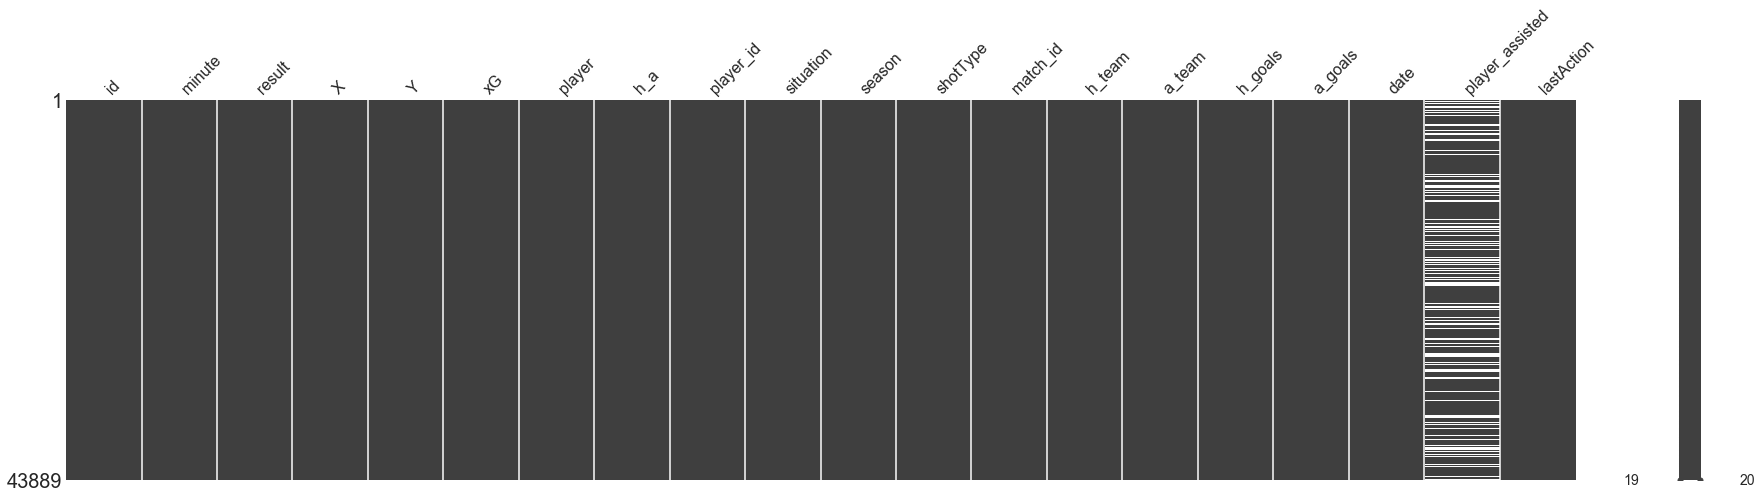

In [26]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_understat_1920_raw
msno.matrix(df_understat_1920_raw, figsize = (30, 7))

In [27]:
# Counts of missing values
tm_null_value_stats = df_understat_1920_raw.isnull().sum(axis=0)
tm_null_value_stats[tm_null_value_stats != 0]

player_assisted    11648
dtype: int64

The visualisation shows us very quickly that the only column that has missing vlaues is the `player_assisted` column, that must be for goals where there was no assist. Our datasets are therefore complete and ready to be engineered.

## <a id='#section4'>4. Data Engineering</a>

### <a id='#section4.1'>4.1. Introduction</a>
Before we answer the questions in the brief through [Exploratory Data Analysis (EDA)](#section5), we'll first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.2'>4.2. Assign Raw DataFrames to New Engineered DataFrames</a>

In [38]:
# Assign Raw DataFrames to new Engineered DataFrames
df_understat_1415 = df_understat_1415_raw
df_understat_1516 = df_understat_1516_raw
df_understat_1617 = df_understat_1617_raw
df_understat_1718 = df_understat_1718_raw
df_understat_1819 = df_understat_1819_raw
df_understat_1920 = df_understat_1920_raw

### <a id='#section4.2'>4.2. Add Season Column to Each Dataset</a>

In [39]:
df_understat_1415['Season'] = '14/15'
df_understat_1516['Season'] = '15/16'
df_understat_1617['Season'] = '16/17'
df_understat_1718['Season'] = '17/18'
df_understat_1819['Season'] = '18/19'
df_understat_1920['Season'] = '19/20'

### <a id='#section4.3'>4.3. Union the Datasets for Individual Seasons</a>

In [40]:
# Union the individual datasets for 14/15, 15/16, 16/17, 17/18, 18/19, and 19/20
df_understat_combined = pd.concat([df_understat_1415, df_understat_1516, df_understat_1617, df_understat_1718, df_understat_1819, df_understat_1920])

### <a id='#section4.4'>4.4. Export Raw DataFrame</a>

In [76]:
# Export the raw Combined DataFrame
df_understat_combined.to_csv(data_dir_understat + '/raw/combined/' + f'combined_big5_last_updated_{today}.csv', index=None, header=True)

### <a id='#section4.5'>4.5. Drop old `season` column</a>

In [41]:
df_understat_combined = df_understat_combined.drop(['season'], axis=1)

### <a id='#section4.6'>4.6. Rename Columns</a>

In [42]:
# Rename columns
df_understat_combined = df_understat_combined.rename({'id': 'id',
                                                      'minute': 'minute',
                                                      'result': 'result',
                                                      'X': 'X',
                                                      'Y': 'Y',
                                                      'xG': 'xG',
                                                      'player': 'player',
                                                      'h_a': 'home_away',
                                                      'player_id': 'player_id',
                                                      'situation': 'situation',
                                                      'shotType': 'shot_type',
                                                      'match_id': 'match_id',
                                                      'h_team': 'home_team',
                                                      'a_team': 'away_team',
                                                      'h_goals': 'home_goals',
                                                      'a_goals': 'away_goals',
                                                      'date': 'kick_off',
                                                      'player_assisted': 'player_assisted',
                                                      'lastAction': 'last_action',
                                                      'Season': 'season'}, axis=1)

### <a id='#section4.7'>4.7. Clean Date</a>

In [43]:
# Clean date column

## Convert 'kick_off' column to datetime
df_understat_combined['kick_off'] = pd.to_datetime(df_understat_combined['kick_off']).dt.strftime('%d-%m-%y %H:%M:%S')

## Create 'date' column from 'kick_off column'
df_understat_combined['date'] = pd.to_datetime(df_understat_combined['kick_off']).dt.strftime('%d-%m-%Y')

## Convert from Object to Datetime
df_understat_combined['kick_off'] = pd.to_datetime(df_understat_combined['kick_off'])
df_understat_combined['date'] = pd.to_datetime(df_understat_combined['date'])

### <a id='#section4.8'>4.8. Create `Year`, `Month` and `Day` columns</a>

In [44]:
df_understat_combined['year'] = pd.DatetimeIndex(df_understat_combined['date']).year
df_understat_combined['month'] = pd.DatetimeIndex(df_understat_combined['date']).month
df_understat_combined['day'] = pd.DatetimeIndex(df_understat_combined['date']).day

### <a id='#section4.9'>4.9. Convert X and Y Coordinates to 120 by 80 coordinates</a>

In [45]:
df_understat_combined['X_120'] = df_understat_combined['X'] * 120
df_understat_combined['Y_120'] = df_understat_combined['Y'] * 80

### <a id='#section4.10'>4.10. Clean column contents</a>

##### `home_away` 

In [55]:
df_understat_combined['home_away'].unique()

array(['Home', 'Away'], dtype=object)

In [48]:
df_understat_combined['home_away'] = df_understat_combined['home_away'].map({'h': 'Home',
                                                                             'a': 'Away'})

##### `result`

In [53]:
df_understat_combined['result'].unique()

array(['SavedShot', 'BlockedShot', 'MissedShots', 'Goal', 'ShotOnPost',
       'OwnGoal'], dtype=object)

In [54]:
df_understat_combined['result'] = df_understat_combined['result'].map({'SavedShot': 'Saved Shot',
                                                                       'BlockedShot': 'Blocked Shots',
                                                                       'MissedShots': 'Missed Shots',
                                                                       'Goal': 'Goal',
                                                                       'ShotOnPost': ' Shot on Post',
                                                                       'OwnGoal': 'Own Goal'})

##### `situation`

In [56]:
df_understat_combined['situation'].unique()

array(['OpenPlay', 'DirectFreekick', 'FromCorner', 'Penalty', 'SetPiece'],
      dtype=object)

In [58]:
df_understat_combined['result'] = df_understat_combined['result'].map({'OpenPlay': 'Open Play',
                                                                       'DirectFreekick': 'Direct Freekick',
                                                                       'FromCorner': 'From Corner',
                                                                       'Penalty': 'Penalty',
                                                                       'SetPiece': 'Set Piece'})

##### `	last_action`

In [57]:
df_understat_combined['last_action'].unique()

array(['Pass', 'TakeOn', 'Standard', 'Aerial', 'Cross', 'Rebound',
       'HeadPass', 'BallRecovery', 'BallTouch', 'None', 'Throughball',
       'Goal', 'Chipped', 'LayOff', 'Dispossessed', 'Tackle', 'Save',
       'Foul', 'BlockedPass', 'Challenge', 'End', 'CornerAwarded',
       'Interception', 'GoodSkill', 'Card', 'Clearance', 'Punch',
       'OffsidePass', 'SubstitutionOn', 'KeeperPickup', 'CrossNotClaimed',
       'FormationChange', 'ChanceMissed', 'ShieldBallOpp', 'Error',
       'KeeperSweeper', 'PenaltyFaced', 'Start', 'OffsideProvoked',
       'Smother', 'SubstitutionOff'], dtype=object)

In [59]:
df_understat_combined['last_action'] = df_understat_combined['last_action'].map({'Pass': 'Pass',
                                                                                 'TakeOn': 'Take On',
                                                                                 'Standard': 'Standard',
                                                                                 'Aerial': 'Aerial',
                                                                                 'Cross': 'Cross',
                                                                                 'Rebound': 'Rebound',
                                                                                 'HeadPass': 'Head Pass',
                                                                                 'BallRecovery': 'Ball Recovery',
                                                                                 'BallTouch': 'Ball Touch',
                                                                                 'None': 'None',
                                                                                 'Throughball': 'Throughball',
                                                                                 'Goal': 'Goal',
                                                                                 'Chipped': 'Chipped',
                                                                                 'LayOff': 'Lay Off',
                                                                                 'Dispossessed': 'Dispossessed',
                                                                                 'Tackle': 'Tackle',
                                                                                 'Save': 'Save',
                                                                                 'Foul': 'Foul',
                                                                                 'BlockedPass': 'Blocked Pass',
                                                                                 'Challenge': 'Challenge',
                                                                                 'End': 'End',
                                                                                 'CornerAwarded': 'Corner Awarded',
                                                                                 'Interception': 'Interception',
                                                                                 'GoodSkill': 'Good Skill',
                                                                                 'Card': 'Card',
                                                                                 'Clearance': 'Clearance',
                                                                                 'Punch': 'Punch',
                                                                                 'OffsidePass': 'Offside Pass',
                                                                                 'SubstitutionOn': 'Substitution On',
                                                                                 'KeeperPickup': 'Keeper Pickup',
                                                                                 'CrossNotClaimed': 'Cross Not Claimed',
                                                                                 'FormationChange': 'Formation Change',
                                                                                 'ChanceMissed': 'Chance Missed',
                                                                                 'ShieldBallOpp': 'Shield Ball Opp',
                                                                                 'Error': 'Error',
                                                                                 'KeeperSweeper': 'Keeper Sweeper',
                                                                                 'PenaltyFaced': 'Penalty Faced',
                                                                                 'Start': 'Start',
                                                                                 'OffsideProvoked': 'Offside Provoked',
                                                                                 'Smother': 'Smother',
                                                                                 'SubstitutionOff': 'Substitution Off'})

### <a id='#section4.11'>4.11. Split the DataFrame by Season</a>
Split the cleaned and organised combined DataFrame by Season.

In [71]:
# Split the cleaned and organised combined DataFrame by Season
df_understat_1415 = df_understat_combined[df_understat_combined['season'] == '14/15']
df_understat_1516 = df_understat_combined[df_understat_combined['season'] == '15/16']
df_understat_1617 = df_understat_combined[df_understat_combined['season'] == '16/17']
df_understat_1718 = df_understat_combined[df_understat_combined['season'] == '17/18']
df_understat_1819 = df_understat_combined[df_understat_combined['season'] == '18/19']
df_understat_1920 = df_understat_combined[df_understat_combined['season'] == '19/20']
#df_understat_2021 = df_understat_combined[df_understat_combined['season'] == '20/21']

### <a id='#section4.12'>4.12. Exporting the Engineered DataFrame</a>
Export the engineered [Understat](https://understat.com/) DataFrame as a single combined CSV file and as seperate files for each season.

In [73]:
# Datetime
import datetime
from datetime import date
import time

In [74]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

In [75]:
# Export the DataFrame

## Combined DataFrame
df_understat_combined.to_csv(data_dir_understat + '/engineered/combined/' + f'combined_big5_last_updated_{today}.csv', index=None, header=True)

## Individual Season DataFrames
df_understat_1415.to_csv(data_dir_understat + '/engineered/1415/' + '1415_big5.csv', index=None, header=True)
df_understat_1516.to_csv(data_dir_understat + '/engineered/1516/' + '1516_big5.csv', index=None, header=True)
df_understat_1617.to_csv(data_dir_understat + '/engineered/1617/' + '1617_big5.csv', index=None, header=True)
df_understat_1718.to_csv(data_dir_understat + '/engineered/1718/' + '1718_big5.csv', index=None, header=True)
df_understat_1819.to_csv(data_dir_understat + '/engineered/1819/' + '1819_big5.csv', index=None, header=True)
df_understat_1920.to_csv(data_dir_understat + '/engineered/1920/' + '1920_big5.csv', index=None, header=True)
#df_understat_2021.to_csv(data_dir_understat + '/engineered/2021/' + f'2021_big5_last_updated_{today}.csv', index=None, header=True)

Now we have created three pandas DataFrames and wrangled the data to meet our needs, we'll next conduct and [Exploratory Data Analysis ](#section5).

## <a id='#section5'>5. Exploratory Data Analysis</a>

### <a id='#section5.1'>5.1. Introduction</a>
...

### <a id='#section5.2'>5.2. ...</a>
...

In [52]:
df_understat_combined.head()

,id,minute,result,X,Y,xG,player,home_away,player_id,situation,...,kick_off,player_assisted,last_action,season,date,year,month,day,X_120,Y_120
0,14511,12,SavedShot,0.728,0.501,0.018741,Wayne Rooney,Home,629,OpenPlay,...,2014-08-16 12:45:00,Darren Fletcher,Pass,14/15,2014-08-16,2014,8,16,87.360004,40.079999
1,14512,16,BlockedShot,0.789,0.336,0.015598,Wayne Rooney,Home,629,OpenPlay,...,2014-08-16 12:45:00,Chicharito,TakeOn,14/15,2014-08-16,2014,8,16,94.680002,26.879999
2,14513,25,SavedShot,0.914,0.188,0.064923,Juan Mata,Home,554,DirectFreekick,...,2014-08-16 12:45:00,NaN,Standard,14/15,2014-08-16,2014,8,16,109.680002,15.039999
3,14514,26,SavedShot,0.920,0.482,0.057788,Wayne Rooney,Home,629,OpenPlay,...,2014-08-16 12:45:00,Ashley Young,Aerial,14/15,2014-08-16,2014,8,16,110.400000,38.560001
4,14516,33,MissedShots,0.922,0.590,0.048801,Wayne Rooney,Home,629,FromCorner,...,2014-08-16 12:45:00,Juan Mata,Cross,14/15,2014-08-16,2014,8,16,110.639996,47.200000


## <a id='#section6'>6. Summary</a>
This notebook engineers scraped [Understat](https://understat.com/) data using [pandas](http://pandas.pydata.org/).

## <a id='#section7'>7. Next Steps</a>
...

## <a id='#section8'>8. References</a>

### <a id='#section8.1'>8.1. Bibliography</a>

#### Data and Web Scraping
*    [Understat](https://understat.com/) for the data to scrape
*    [Ben Torvaney](https://twitter.com/Torvaney)'s [Understat Scraper in R](https://gist.github.com/Torvaney/42cd82addb3ba2c4f33ec3247e66889c)

## <a id='#section9.2'>8.2. Python Techniques Observed</a>
To conduct our analysis, we have used the following libraries and modules for the following tasks:
*    [NumPy](http://www.numpy.org/) for multidimensional array computing,
*    [pandas](http://pandas.pydata.org/) for data manipulation and ingestion, and
*    [Beautifulsoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) for scraping data from webpages.

We have also demonstrated an array of techniques in Python using the following methods and functions:
*    pandas EDA methods:
     +    [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html),
     +    [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html),
     +    [shape](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [columns](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.columns.html),
     +    [dtypes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html),
     +    [info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html), and
     +    [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).
*    The [missingno](https://pypi.org/project/missingno/) library to visualise how many missing values we have in the dataset, and
*    The pandas [.to_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method to export the DataFrames as csv files.

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)